In [5]:
from ib_insync import util, IB
import logging

util.startLoop()
util.logToConsole(logging.INFO)

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=0)

2025-07-05 14:43:39,560 ib_insync.client INFO Connecting to 127.0.0.1:7497 with clientId 0...
2025-07-05 14:43:39,563 ib_insync.client INFO Connected
2025-07-05 14:43:39,591 ib_insync.client INFO Logged on to server version 176
2025-07-05 14:43:39,598 ib_insync.client INFO API connection ready
2025-07-05 14:43:39,600 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:usfarm.nj
2025-07-05 14:43:39,600 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:hfarm
2025-07-05 14:43:39,601 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:usfuture
2025-07-05 14:43:39,603 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
2025-07-05 14:43:39,603 ib_insync.wrapper INFO Warning 2104, reqId -1: Market data farm connection is OK:usfarm
2025-07-05 14:43:39,603 ib_insync.wrapper INFO Warning 2106, reqId -1: HMDS data farm connection is OK:apachmds
2025-07-05 14:43:39,604 ib_

<IB connected to 127.0.0.1:7497 clientId=0>

2025-07-05 14:48:29,786 ib_insync.wrapper ERROR Error 10299, reqId 7: Expected what to show is AGGTRADES, please use that instead of TRADES., contract: Contract(secType='CRYPTO', symbol='BTC', exchange='PAXOS', currency='USD')
2025-07-05 14:48:30,518 ib_insync.wrapper ERROR Error 162, reqId 7: Historical Market Data Service error message:No market data permissions for PAXOS CRYPTO
2025-07-05 19:17:14,025 ib_insync.wrapper INFO Warning 2103, reqId -1: Market data farm connection is broken:hfarm
2025-07-05 19:17:14,923 ib_insync.wrapper INFO Warning 2157, reqId -1: Sec-def data farm connection is broken:secdefhk
2025-07-05 19:17:14,950 ib_insync.wrapper INFO Warning 2105, reqId -1: HMDS data farm connection is broken:apachmds
2025-07-05 19:17:17,446 ib_insync.wrapper INFO Warning 2105, reqId -1: HMDS data farm connection is broken:ushmds
2025-07-05 19:17:17,449 ib_insync.wrapper INFO Warning 2158, reqId -1: Sec-def data farm connection is OK:secdefhk
2025-07-05 19:17:17,566 ib_insync.wra

In [6]:
from ib_insync import Stock, Contract

# Assume we find the unique stock contract for micro strategy
mstr = Stock('MSTR', 'SMART', 'USD')
assert len(ib.reqContractDetails(mstr)) == 1
ib.qualifyContracts(mstr)
mstr

Stock(conId=272110, symbol='MSTR', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='MSTR', tradingClass='NMS')

In [7]:
import pandas as pd

async def get_historical_data_ib(ib: IB, contract: Contract, duration: str, bar_size: str, what_to_show: str = 'TRADES', use_rth: bool = True, formatDate: str = '1', keepUpToDate: bool = False) -> pd.DataFrame:
    """
    Requests historical market data for a given contract from Interactive Brokers (IB) using ib_insync.

    Args:
        ib (IB): The ib_insync IB client instance.
        contract (Contract): The IB Contract object specifying the security.
        duration (str): The duration string for the historical data request (e.g., '1 Y', '3 M', '1 W', '1 D', '30 D', '1 H', '30 mins').
        bar_size (str): The bar size for the historical data (e.g., '1 secs', '5 secs', '1 min', '5 mins', '1 hour', '1 day').
        what_to_show (str, optional): The type of data to retrieve (e.g., 'TRADES', 'MIDPOINT', 'BID', 'ASK', 'BID_ASK', 'HISTORICAL_VOLATILITY', 'OPTION_IMPLIED_VOLATILITY'). Defaults to 'TRADES'.
        use_rth (bool, optional): Whether to retrieve data only during regular trading hours. Defaults to True.
        formatDate (str, optional): The format of the date in the returned data ('1' for YYYYMMDD HH:MM:SS, '2' for system time in seconds). Defaults to '1'.
        keepUpToDate (bool, optional): If True, the historical data will be updated in real-time. Note: This requires the function to run continuously. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame containing the historical market data with columns:
                          ['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount'].
                          Returns an empty DataFrame if no data is received or if there's an error.
    """
    try:
        bars = await ib.reqHistoricalDataAsync(
            contract,
            endDateTime="20250628 16:00:00 US/Eastern", #set to 20250628 since bitcoin price is downloaded to this date
            durationStr=duration,
            barSizeSetting=bar_size,
            whatToShow=what_to_show,
            useRTH=use_rth,
            formatDate=formatDate,
            keepUpToDate=keepUpToDate
        )
        if bars:
            df = pd.DataFrame([vars(bar) for bar in bars])
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
            return df
        else:
            print(f"No historical data received for {contract.symbol} with duration '{duration}' and bar size '{bar_size}'.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error requesting historical data for {contract.symbol}: {e}")
        return pd.DataFrame()


In [8]:
mstr_his_df = await get_historical_data_ib(ib, mstr, '5 Y', '1 day')
display(mstr_his_df.head())

,date,open,high,low,close,volume,average,barCount
0,2020-06-29,11.72,11.97,11.72,11.85,105040.0,11.8382,97
1,2020-06-30,11.81,11.98,11.77,11.83,173190.0,11.8545,153
2,2020-07-01,11.78,12.00,11.77,11.78,86670.0,11.8397,77
3,2020-07-02,11.87,11.94,11.70,11.74,192180.0,11.8139,178
4,2020-07-06,11.88,12.07,11.79,11.97,278750.0,11.9313,247


In [9]:
print(mstr_his_df.dtypes)


date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume             float64
average            float64
barCount             int64
dtype: object


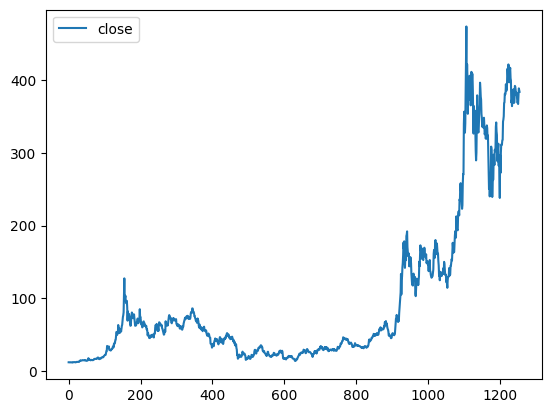

In [12]:
import matplotlib
%matplotlib inline
mstr_his_df.plot(y='close');

In [13]:
# No historical data in account...
spot_btc_contract = Contract(symbol='BTC', secType='CRYPTO', exchange='PAXOS', currency='USD')
ib.reqContractDetails(spot_btc_contract)
btc_his_df = await get_historical_data_ib(ib, spot_btc_contract, '7 D', '1 hour')
display(btc_his_df.head())

No historical data received for BTC with duration '7 D' and bar size '1 hour'.


""


## Does not have BTC data from IB

In [21]:
def read_bitcoin_historical_data(csv_filepath):
    try:
        df = pd.read_csv(csv_filepath)
        # print("\n--- Pandas DataFrame ---")
        # print("DataFrame Head:")
        # print(df.head())
        # print("\nDataFrame Info (data types):")
        # df.info()
        return df.sort_values(by='Start', ascending=True).reset_index(drop=True)
        # # reverse to get ascending
        # df = df.iloc[::-1]
    
        # date_and_open_price_df = df[['Start', 'Open']]
        # # get the reversed array
        # date_and_open_price_array = date_and_open_price_df.to_numpy()
        # print(date_and_open_price_array)
    
        # TODO: figure out how to call utils.segmentation.py
    
    except FileNotFoundError:
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

bitcoin_his_df = read_bitcoin_historical_data("data/bitcoin_2020-06-30_2025-06-29.csv")
bitcoin_his_df['Start'] = pd.to_datetime(bitcoin_his_df['Start']) #convert object column to datetime64
bitcoin_his_df['End'] = pd.to_datetime(bitcoin_his_df['End'])
print(bitcoin_his_df.dtypes)
display(bitcoin_his_df.head())



Start         datetime64[ns]
End           datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object


,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2020-06-30,2020-07-01,9179.411116,9190.720681,9076.059608,9145.560607,1.542112e+10,1.685325e+11
1,2020-07-01,2020-07-02,9136.040257,9283.111145,9102.358834,9225.668161,1.504327e+10,1.692277e+11
2,2020-07-02,2020-07-03,9228.082821,9253.257937,8991.466116,9084.054479,1.636875e+10,1.688136e+11
3,2020-07-03,2020-07-04,9081.573979,9117.536881,9059.787936,9065.577985,1.609372e+10,1.674741e+11
4,2020-07-04,2020-07-05,9069.815386,9178.139100,9053.808489,9127.518467,1.261937e+10,1.674297e+11


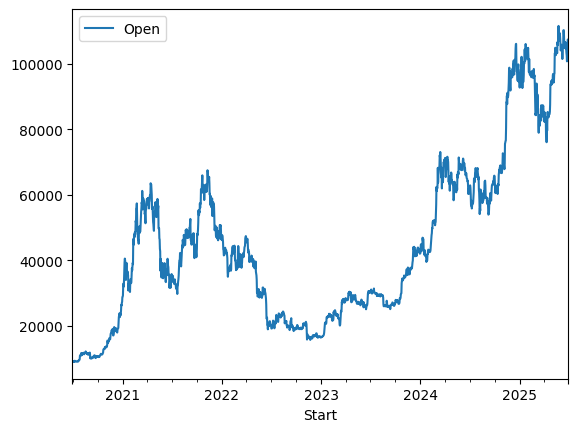

In [20]:
bitcoin_his_df.plot(x='Start', y='Open');

In [22]:
# bitcoin_his_df = bitcoin_his_df.[(bitcoin_his_df['Date'] >= pd.to_datetime('2024-05-02'))]
mstr_btc_df = pd.merge(mstr_his_df, bitcoin_his_df, left_on='date', right_on='Start', how='left', suffixes=('_mstr', '_btc'))
display(mstr_btc_df.head())

,date,open,high,low,close,volume,average,barCount,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2020-06-29,11.72,11.97,11.72,11.85,105040.0,11.8382,97,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-30,11.81,11.98,11.77,11.83,173190.0,11.8545,153,2020-06-30,2020-07-01,9179.411116,9190.720681,9076.059608,9145.560607,1.542112e+10,1.685325e+11
2,2020-07-01,11.78,12.00,11.77,11.78,86670.0,11.8397,77,2020-07-01,2020-07-02,9136.040257,9283.111145,9102.358834,9225.668161,1.504327e+10,1.692277e+11
3,2020-07-02,11.87,11.94,11.70,11.74,192180.0,11.8139,178,2020-07-02,2020-07-03,9228.082821,9253.257937,8991.466116,9084.054479,1.636875e+10,1.688136e+11
4,2020-07-06,11.88,12.07,11.79,11.97,278750.0,11.9313,247,2020-07-06,2020-07-07,9077.942345,9342.540316,9053.655688,9342.540316,1.679409e+10,1.696049e+11


In [23]:
mstr_btc_df_plot = mstr_btc_df[['date', 'open', 'close', 'Open', 'Close']].rename(columns={'open': 'open_mstr', 'close': 'close_mstr', 'Open': 'open_btc', 'Close':'close_btc'})
mstr_btc_df_plot.head()

,date,open_mstr,close_mstr,open_btc,close_btc
0,2020-06-29,11.72,11.85,NaN,NaN
1,2020-06-30,11.81,11.83,9179.411116,9145.560607
2,2020-07-01,11.78,11.78,9136.040257,9225.668161
3,2020-07-02,11.87,11.74,9228.082821,9084.054479
4,2020-07-06,11.88,11.97,9077.942345,9342.540316


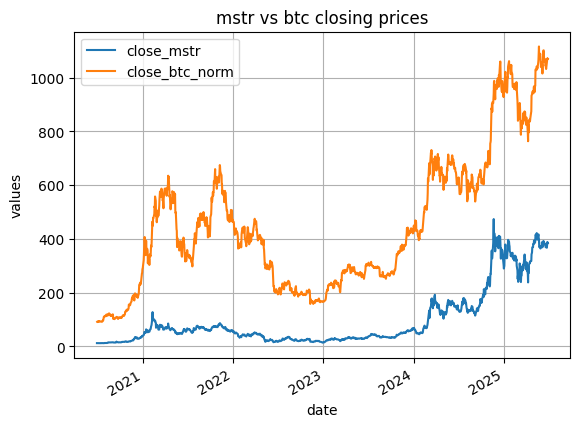

In [24]:
#Normalize BTC price
mstr_btc_df_plot['close_btc_norm'] = mstr_btc_df_plot['close_btc'] / 100
mstr_btc_df_plot.head()

import matplotlib.pyplot as plt

# Plot 'Y1' and 'Y2' against 'X'
mstr_btc_df_plot.plot(x='date', y=['close_mstr', 'close_btc_norm'])
plt.title('mstr vs btc closing prices')
plt.xlabel('date')
plt.ylabel('values')
plt.legend(['close_mstr', 'close_btc_norm'])  # Customize the legend labels
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

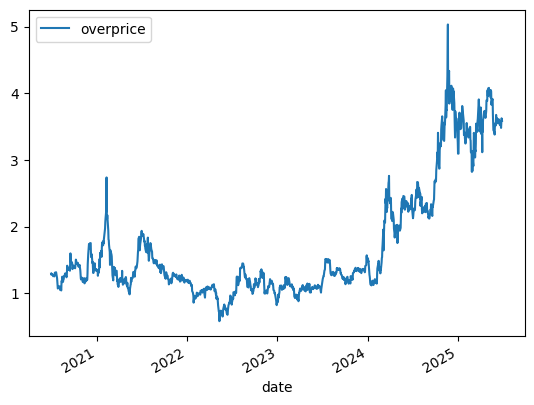

In [30]:
mstr_btc_df_plot['overprice'] = mstr_btc_df_plot['close_mstr']/mstr_btc_df_plot['close_btc']
mstr_btc_df_plot['overprice'] = mstr_btc_df_plot['overprice'] * 1000 #normalize
mstr_btc_df_plot.plot(x='date', y=['overprice'])

In [49]:
# TODO: compute correlations?n
from bitfund.utils import segmentation_running as sgr
import numpy as np

def plot_segments(date_and_open_price_array, segments):
    time = date_and_open_price_array[:, 0].tolist()
    price = date_and_open_price_array[:, 1].tolist()
    for i, seg in enumerate(segments):
        # When printing, use seg[0, 0] for x_start and seg[-1, 0] for x_end
        print(f"Segment {i + 1}: from x={seg[0, 0]} to x={seg[-1, 0]} (length {len(seg)})")
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(time, price, 'o-', markersize=3, label='Original Data')
    
    colors = plt.cm.get_cmap('viridis', len(segments))
    for i, segment in enumerate(segments):
        seg_x = segment[:, 0]
        seg_y = segment[:, 1]
        plt.plot(seg_x, seg_y, '-', linewidth=3, color=colors(i), label=f'Segment {i + 1}')
    
        # Plot the mean value for the constant model
        if len(seg_y) > 0:
            mean_val = np.mean(seg_y)
            plt.plot(seg_x, [mean_val] * len(seg_x), '--', color='black', linewidth=1)
    
    plt.title(f'Time Series Segmentation (Constant Model, NumPy Input, Penalty: {penalty_lambda})')
    plt.xlabel('Time (x)')
    plt.ylabel('Price (y)')
    plt.legend()
    plt.grid(True)
    plt.show()

mstr_btc_seg_df = mstr_btc_df_plot[['date','overprice']]
mstr_btc_seg_df = mstr_btc_seg_df.dropna(subset=['overprice']) # Drop missing NAN price
mstr_btc_seg_array = mstr_btc_seg_df.to_numpy()
sgr_penalty = 3
segmenter = sgr.ConsistentRunningSegmenter(initial_data_array=mstr_btc_seg_array,
                                           penalty_lambda=sgr_penalty,
                                           cost_func='constant')
print(f"Found {len(segmenter.get_segments())} segments.")
for i, seg in enumerate(segmenter.get_segments()):
    print(f"Segment {i + 1}: from x={seg[0, 0]} to x={seg[-1, 0]} (length {len(seg)})")


Initial batch segmentation completed with 11 segments.
Found 11 segments.
Segment 1: from x=2020-06-30 00:00:00 to x=2021-01-20 00:00:00 (length 141)
Segment 2: from x=2021-01-21 00:00:00 to x=2021-02-22 00:00:00 (length 22)
Segment 3: from x=2021-02-23 00:00:00 to x=2021-06-11 00:00:00 (length 77)
Segment 4: from x=2021-06-14 00:00:00 to x=2021-09-29 00:00:00 (length 76)
Segment 5: from x=2021-09-30 00:00:00 to x=2023-06-30 00:00:00 (length 440)
Segment 6: from x=2023-07-03 00:00:00 to x=2024-03-01 00:00:00 (length 168)
Segment 7: from x=2024-03-04 00:00:00 to x=2024-10-03 00:00:00 (length 149)
Segment 8: from x=2024-10-04 00:00:00 to x=2024-11-08 00:00:00 (length 26)
Segment 9: from x=2024-11-11 00:00:00 to x=2024-12-16 00:00:00 (length 25)
Segment 10: from x=2024-12-17 00:00:00 to x=2025-03-19 00:00:00 (length 62)
Segment 11: from x=2025-03-20 00:00:00 to x=2025-06-27 00:00:00 (length 69)


Segment 1: from x=2020-06-30 00:00:00 to x=2021-01-20 00:00:00 (length 141)
Segment 2: from x=2021-01-21 00:00:00 to x=2021-02-22 00:00:00 (length 22)
Segment 3: from x=2021-02-23 00:00:00 to x=2021-06-11 00:00:00 (length 77)
Segment 4: from x=2021-06-14 00:00:00 to x=2021-09-29 00:00:00 (length 76)
Segment 5: from x=2021-09-30 00:00:00 to x=2023-06-30 00:00:00 (length 440)
Segment 6: from x=2023-07-03 00:00:00 to x=2024-03-01 00:00:00 (length 168)
Segment 7: from x=2024-03-04 00:00:00 to x=2024-10-03 00:00:00 (length 149)
Segment 8: from x=2024-10-04 00:00:00 to x=2024-11-08 00:00:00 (length 26)
Segment 9: from x=2024-11-11 00:00:00 to x=2024-12-16 00:00:00 (length 25)
Segment 10: from x=2024-12-17 00:00:00 to x=2025-03-19 00:00:00 (length 62)
Segment 11: from x=2025-03-20 00:00:00 to x=2025-06-27 00:00:00 (length 69)


/var/folders/yq/c0h4z5t54_j3kff7h_6n6w940000gn/T/ipykernel_49630/636359399.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(segments))


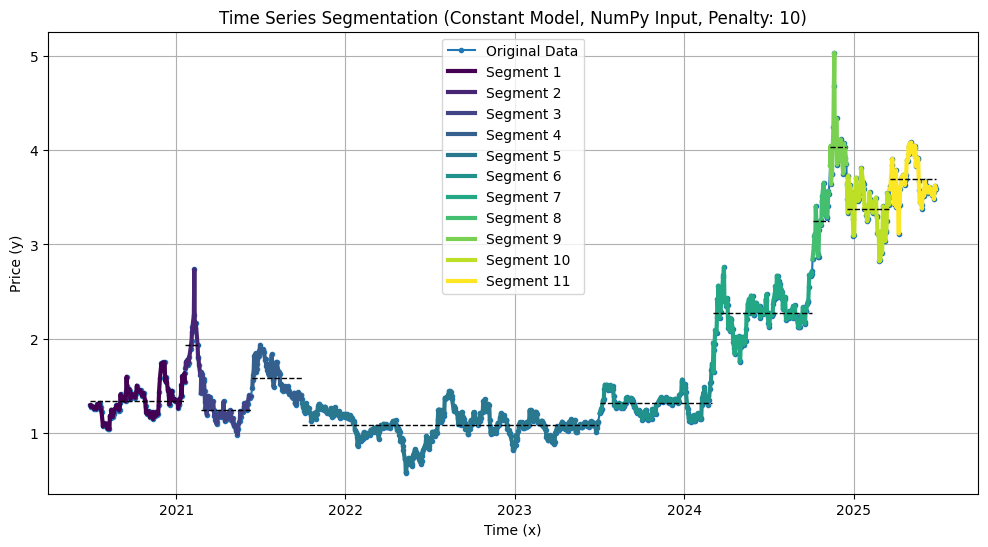

In [50]:
plot_segments(mstr_btc_seg_array, segmenter.get_segments())